In [1]:
%matplotlib inline
%timeit
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sys
from collections import Counter
import random
import ast
import re
import scipy

sys.path.append('pymodules')
# This class contains some utility functions Word2Vec, stop words etc. etc.
import pymodules.preprocessing_class as pc

# gender gueser
import gender_guesser.detector as gd

# for dictionary method synonym finder using wordnet
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error

from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

# (VII)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
# model/ensemble scorer ...
from sklearn.metrics import make_scorer

##########
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix, f1_score
# model/ensemble scorer ...
from sklearn.metrics import make_scorer

import multiprocess as mp

# from https://stackoverflow.com/questions/7370801/how-do-i-measure-elapsed-time-in-python
from timeit import default_timer as timer

/Users/bmukund/miniconda3/lib/python3.8/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
[nltk_data] Downloading package wordnet to /Users/bmukund/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/bmukund/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
def find_wordnet_synonyms(word_list, type_of_word=None):
    """ it is assumed that the word_list words are themselves synonyms and is given as a list (even if there is only one word
    return lemmatized synonyms ...
    """
    synonyms = set()
    for word_to_look in word_list:
        #print(f"looking for synonyms of word:{word_to_look}")
        for syn in wn.synsets(word_to_look, pos=type_of_word):
            for i in syn.lemmas():
                synonyms.add(i.name())
    #print(f"Synonyms:\n {synonyms}")
    return synonyms

In [3]:
# Function to get the first name so that we can guess the gender
def first_name(x):
    """
    We determine the first name from the given string. We also remove any digits from the name. 
    Further, we use space to split names
    """
    x_split = str(x).split()
    fname = x_split[0]
    # remove reference to digits. Now after removal, there could be some misclassification, but that is ok ..
    fname_p = re.sub(r'[0-9]+', "", fname)
    ret_str = fname_p.capitalize()
    return ret_str


In [4]:
# for parallel run of multiple trials ...
def run_parallel(func, num_cpus=4):
    """
    A simple parallel processor
    """
    mp_pool = mp.Pool(num_cpus)

    def _run(grid_parameters):
        result = mp_pool.map(func, grid_parameters)
        return result

    return _run


# Ref: https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/
def onehot_encode(data):
    """
    one hot encoding for CNN
    """
    return to_categorical(data)


# load dataset
def split_data(X, y, validation=False, shuffle=False):
    """
    load data and create validation set as well (25% of training data)
    """
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=shuffle)
    # create validation data as well
    if validation:
        trainX, validX, trainy, validy = train_test_split(trainX, trainy, test_size=0.25, random_state=42,
                                                          shuffle=shuffle)
        return trainX, trainy, testX, testy, validX, validy
    else:
        return trainX, trainy, testX, testy, None, None


def plot_accuracy(model, test_str='Validation'):
    plt.plot(model.history['accuracy'])
    plt.plot(model.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', test_str], loc='upper left')
    plt.show()


def plot_loss(model, test_str='Validation'):
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', test_str], loc='upper left')
    plt.show()


def convert_prob_to_labels(data):
    # the outputs are probabilities, change it to classifier labels ..
    y_arg = np.argmax(data, axis=1)
    y_pred = onehot_encode(y_arg)
    return y_pred


def model_stats_all_labels(Y_pred, Y_actual):
    # true negatives is  C[0, 0]
    # false negatives is C[1, 0]
    # true positives is  C[1, 1]
    # false positives is C[0, 1]
    mcm = multilabel_confusion_matrix(Y_actual, Y_pred)
    tnv = mcm[:, 0, 0]
    tpv = mcm[:, 1, 1]
    fnv = mcm[:, 1, 0]
    fpv = mcm[:, 0, 1]

    accuracy = (tpv + tnv) / (tpv + tnv + fpv + fnv)
    sensitivity = tpv / (tpv + fnv)
    specificity = tnv / (tnv + fpv)
    denom = 1 - specificity
    likelihood = [sensitivity[i] / denom[i] if denom[i] > 0 else np.nan for i in range(len(denom))]

    return accuracy, sensitivity, specificity, likelihood

In [5]:
filename = "data/Master-data_Q42021.xlsx"
text_data_raw = pd.read_excel(filename, sheet_name='Scrubbed_data', index_col='REVIEW_DATE')

# We don't need these columns
not_needed = ['OVERALL_RATING', 'COMFORT_RATING', 'VISION_RATING', 'VALUE_FOR_MONEY', 'PROS', 'CONS', 'ORIGINAL_SOURCE', 'REPLY_FROM_ACCUVUE',
'PRODUCT_LINK', 'WEBSITE']

text_data = text_data_raw.drop(columns = not_needed, axis=1)


In [6]:
# Let us figure out the gender from the names and drop the names column
# We use gender_guesser package.
#text_data['AUTHOR'] = text_data['AUTHOR'].astype(str)
gdx = gd.Detector()
text_data['GENDER'] = text_data.AUTHOR.apply(first_name).map(lambda x: gdx.get_gender(x))

# Drop the author column now
text_data.drop(columns = ['AUTHOR'], axis=1, inplace=True)

# Check the gender counts just to see how the data looks like
text_data.GENDER.value_counts()

female           4003
male             2400
unknown          1556
mostly_female     464
mostly_male       253
andy              118
Name: GENDER, dtype: int64

In [7]:
# Consolidate the comments into one column
# Comments can occur both in title and in Comment columns. 
text_data['COMMENT'] = text_data['TITLE'].astype(str).fillna("") + " " + text_data['COMMENTS'].astype(str).fillna("")
text_data.drop(columns = ['TITLE', 'COMMENTS'], axis=1, inplace=True)

In [8]:
# clean rating
# replace N = No rating with 0. We do this because rating is assumed to be numeric, not categorical
text_data['RATING'].replace('N', '0', inplace=True)
# convert rating to integers
text_data['RATING'] = text_data['RATING'].apply(lambda x: int(x))

In [9]:
# display results
text_data

,FINAL_PRODUCT_NAME,RATING,PRODUCT,BRAND,GENDER,COMMENT
REVIEW_DATE,,,,,,
2021-11-01,Acuvue 2 Contact Lenses ...,5,Acuvue2,Acuvue,male,Acucue 2 Contact Lenses I have used these lens...
2021-12-02,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,female,Clear vision Tends to cloud up
2021-12-01,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,female,comfort These are very hard to handle. Flimsy ...
2021-11-16,Acuvue 2 Contact Lenses ...,5,Acuvue2,Acuvue,male,Easy to use I have been using this product for...
2021-12-08,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,unknown,Excellent Excellent got promised a discount of...
...,...,...,...,...,...,...
2021-11-29,Acuvue VITA Contact Lenses ...,5,Vita,Acuvue,male,"Truly the Best The price, fast shipping, quic..."
2021-11-23,Shop Acuvue Vita 12 pack (1.0 Box ),5,Vita,Acuvue,male,Very Comfortable Acuvue Vita are very comfort...
2021-12-27,Acuvue Vita for Astigmatism Contact Lenses,5,Vita,Acuvue,male,Very Comfortable and Convenient Very Comfortab...


### Tokenization

In [10]:
## regex for tokenization
# Ref: http://sentiment.christopherpotts.net/code-data/happyfuntokenizing.py
emoticon_string = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
    )"""

# The components of the tokenizer:
regex_strings = (
    # Phone numbers:
    r"""
    (?:
      (?:            # (international)
        \+?[01]
        [\-\s.]*
      )?
      (?:            # (area code)
        [\(]?
        \d{3}
        [\-\s.\)]*
      )?
      \d{3}          # exchange
      [\-\s.]*
      \d{4}          # base
    )"""
    ,
    # Emoticons:
    emoticon_string
    ,
    # HTML tags:
    r"""<[^>]+>"""
    ,
    # Twitter username:
    r"""(?:@[\w_]+)"""
    ,
    # Twitter hashtags:
    r"""(?:\#+[\w_]+[\w\'_\-]*[\w_]+)"""
    ,
    # Remaining word types:
    r"""
    (?:[a-z][a-z'\-_]+[a-z])       # Words with apostrophes or dashes.
    |
    (?:[+\-]?\d+[,/.:-]\d+[+\-]?)  # Numbers, including fractions, decimals.
    |
    (?:[\w_]+)                     # Words without apostrophes or dashes.
    |
    (?:\.(?:\s*\.){1,})            # Ellipsis dots.
    |
    (?:\S)                         # Everything else that isn't whitespace.
    """,
    r"""
    (?x)                # set flag to allow verbose regexps (to separate logical sections of pattern and add comments)
    \w+(?:-\w+)*        # preserve expressions with internal hyphens as single tokens
    | [][.,;"'?():-_`]  # preserve punctuation as separate tokens
    """
)
word_re = re.compile(pattern=r"""(%s)""" % "|".join(regex_strings), flags=re.VERBOSE | re.I)

/var/folders/bk/93tv9tk147s32tbjbfrfb79w0000gn/T/ipykernel_54486/2438410962.py:65: DeprecationWarning: Flags not at the start of the expression '(\n    (?:\n      (?: ' (truncated)
  word_re = re.compile(pattern=r"""(%s)""" % "|".join(regex_strings), flags=re.VERBOSE | re.I)


In [11]:
comments_data = text_data.COMMENT
prep_comments = pc.RawDocs(comments_data,  # series of documents
                  lower_case=True,  # whether to lowercase the text in the firs cleaning step
                  stopwords='long',  # type of stopwords to initialize
                  contraction_split=True,  # wheter to split contractions or not
                  tokenization_pattern=word_re  # custom tokenization patter
                  )

In [12]:
# notice that the documents from the object are identical to the ones from the pandas series
#comments_data
i = 0
print("Document from the pandas series:\n", comments_data[i])
print("\n-------------------------\n")
print("Document from preprocessing object:\n", prep_comments.docs[i])


Document from the pandas series:
 Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!

-------------------------

Document from preprocessing object:
 Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!


In [13]:
# lower-case text, expand contractions and initialize stopwords list
prep_comments.basic_cleaning()

In [14]:
# explore an example after the basic cleaning has been applied
i = 0
print(comments_data[i])
print()
print(prep_comments.docs[i])


Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!

acucue 2 contact lenses i have used these lenses for a long time and i have to say that the service from lens.com is great and the lenses work great for my needs!  i highly recommend them!


In [15]:
# now we can split the documents into tokens
prep_comments.tokenize_text()

In [16]:
i = 0
print(comments_data[i])
print()
print(prep_comments.tokens[i])

Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!

['acucue', '2', 'contact', 'lenses', 'i', 'have', 'used', 'these', 'lenses', 'for', 'a', 'long', 'time', 'and', 'i', 'have', 'to', 'say', 'that', 'the', 'service', 'from', 'lens', '.', 'com', 'is', 'great', 'and', 'the', 'lenses', 'work', 'great', 'for', 'my', 'needs', '!', 'i', 'highly', 'recommend', 'them', '!']


In [17]:
punctuation = string.punctuation
punctuation = punctuation.replace("-", "") # remove the hyphen from the punctuation string
punctuation

'!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [18]:
prep_comments.token_clean(length=2,                 # remove tokens with less than this number of characters
                 punctuation=punctuation,           # remove custom list of punctuation characters
                 numbers = True                     # remove numbers
                 )


In [19]:
i = 0
print(comments_data[i])
print()
print(prep_comments.tokens[i])


Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!

['acucue', 'contact', 'lenses', 'have', 'used', 'these', 'lenses', 'for', 'long', 'time', 'and', 'have', 'say', 'that', 'the', 'service', 'from', 'lens', 'com', 'great', 'and', 'the', 'lenses', 'work', 'great', 'for', 'needs', 'highly', 'recommend', 'them']


In [20]:
# get the list of stopwords provided earlier
print(sorted(prep_comments.stopwords))

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'also', 'am', 'an', 'and', 'another', 'any', 'are', 'as', 'at', 'back', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'could', 'did', 'do', 'does', 'doing', 'down', 'during', 'each', 'even', 'ever', 'every', 'few', 'first', 'five', 'for', 'four', 'from', 'further', 'get', 'go', 'goes', 'had', 'has', 'have', 'having', 'he', 'her', 'here', 'hers', 'herself', 'high', 'him', 'himself', 'his', 'how', 'however', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'itself', 'just', 'least', 'less', 'like', 'long', 'made', 'make', 'many', 'me', 'more', 'most', 'my', 'myself', 'never', 'new', 'no', 'nor', 'not', 'now', 'of', 'off', 'old', 'on', 'once', 'one', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'put', 'said', 'same', 'say', 'says', 'second', 'see', 'seen', 'she', 'should', 'since', 'so', 'some', 'still', 'such', 'take', 'than', 'that', 'the', 'their', 'theirs'

In [21]:
# we need to specificy that we want to remove the stopwords from the "tokens"
prep_comments.stopword_remove('tokens')

In [22]:
i = 0
print(comments_data[i])
print()
print(prep_comments.tokens[i])


Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!

['acucue', 'contact', 'lenses', 'used', 'lenses', 'time', 'service', 'lens', 'com', 'great', 'lenses', 'work', 'great', 'needs', 'highly', 'recommend']


In [23]:
# stemming
# pre_comments.stem()

# apply lemmatization to all documents (takes a very long time so we will avoid it for now)
prep_comments.lemmatize()

In [24]:
# compare all versions of the same raw sentences
i = 0
print(comments_data[i])
print()
print(prep_comments.tokens[i])
print()
# print(prep_comments.stems[i])
# print()
print(prep_comments.lemmas[i])


Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!

['acucue', 'contact', 'lenses', 'used', 'lenses', 'time', 'service', 'lens', 'com', 'great', 'lenses', 'work', 'great', 'needs', 'highly', 'recommend']

['acucue', 'contact', 'lense', 'use', 'lense', 'time', 'service', 'lens', 'com', 'great', 'lense', 'work', 'great', 'need', 'highly', 'recommend']


In [25]:
prep_comments.get_term_ranking(items='tokens', score_type='df')
prep_comments.df_ranking['tokens'][:15]


[(1956.0, 'comfortable', 0),
 (1643.0, 'contacts', 1),
 (1597.0, 'great', 2),
 (1425.0, 'lenses', 3),
 (1002.0, 'eyes', 4),
 (983.0, 'good', 5),
 (872.0, 'day', 6),
 (842.0, 'easy', 7),
 (810.0, 'contact', 8),
 (767.0, 'wear', 9),
 (695.0, 'price', 10),
 (693.0, 'product', 11),
 (692.0, 'years', 12),
 (588.0, 'lens', 13),
 (581.0, 'love', 14)]

TF-IDF weights more words that occur frequently but in less number of documents. This seems to skew ranking towards advertisement like reviews. (See output) It is not clear if such counting is relevant for this project.

In [26]:
prep_comments.get_term_ranking(items='tokens', score_type='tfidf')
prep_comments.tfidf_ranking['tokens'][:10]


[(28.39211864825375, 'freshlook', 0),
 (28.36511786875115, 'focus', 1),
 (28.240281202733275, 'frequency', 2),
 (28.090056961353014, 'green', 3),
 (28.02474931757409, 'colorblends', 4),
 (27.975072702813453, 'advance', 5),
 (27.918162541618855, 'brown', 6),
 (27.917854650349692, 'optima', 7),
 (27.809817055575433, 'soflens', 8),
 (27.78312736349992, 'proclear', 9)]

In [27]:
prep_comments.df_ranking['tokens'][-10:]

[(1.0, 'written', 183),
 (1.0, 'wrote', 183),
 (1.0, 'xc-best', 183),
 (1.0, 'xrs', 183),
 (1.0, 'xxxx', 183),
 (1.0, 'xxxxx', 183),
 (1.0, 'yearly', 183),
 (1.0, 'yesrs', 183),
 (1.0, 'yiur', 183),
 (1.0, 'yucky', 183)]

In [28]:
prep_comments.tfidf_ranking['tokens'][-15:]


[(8.388677769180811, 'worrying', 475),
 (8.388677769180811, 'wourd', 475),
 (8.388677769180811, 'wrap', 475),
 (8.388677769180811, 'wrapped', 475),
 (8.388677769180811, 'wrinkle', 475),
 (8.388677769180811, 'written', 475),
 (8.388677769180811, 'wrote', 475),
 (8.388677769180811, 'xc-best', 475),
 (8.388677769180811, 'xrs', 475),
 (8.388677769180811, 'xxxx', 475),
 (8.388677769180811, 'xxxxx', 475),
 (8.388677769180811, 'yearly', 475),
 (8.388677769180811, 'yesrs', 475),
 (8.388677769180811, 'yiur', 475),
 (8.388677769180811, 'yucky', 475)]

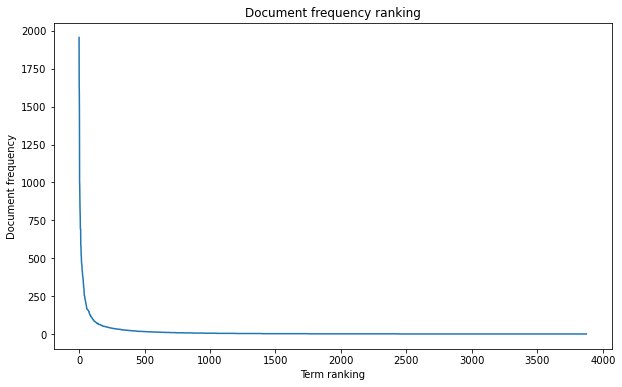

In [29]:
plt.figure(figsize=(10,6))
plt.plot([x[0] for x in prep_comments.df_ranking['tokens']])
plt.title('Document frequency ranking')
plt.ylabel("Document frequency")
plt.xlabel("Term ranking")
plt.show()


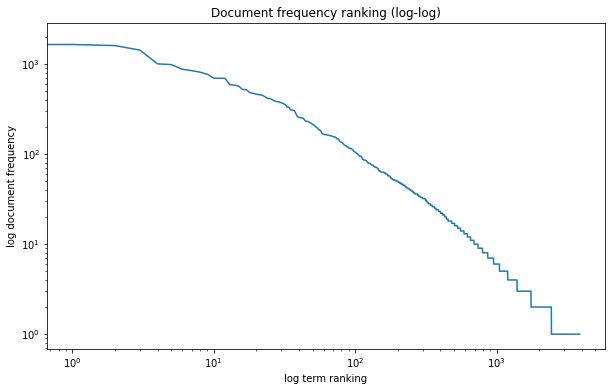

In [30]:
# we can use a log-log scale to observe more clearly the power-law distribution (Zipf's law)
plt.figure(figsize=(10,6))
plt.loglog([x[0] for x in prep_comments.df_ranking['tokens']])
plt.title('Document frequency ranking (log-log)')
plt.ylabel("log document frequency")
plt.xlabel("log term ranking")
plt.show()


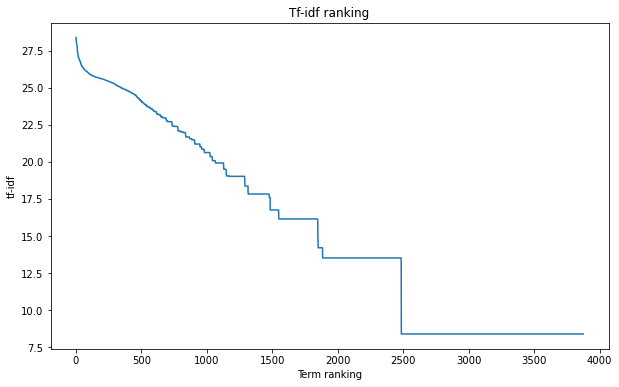

In [31]:
plt.figure(figsize=(10,6))
plt.plot([x[0] for x in prep_comments.tfidf_ranking['tokens']])
plt.title('Tf-idf ranking')
plt.ylabel("tf-idf")
plt.xlabel("Term ranking")
plt.show()


### Vectorization

In [32]:
# simple auxiliary function to override the preprocessing done by sklearn
def do_nothing(doc):
    return doc


In [33]:
# create a CountVectorizer object using our preprocessed text
count_vectorizer = CountVectorizer(encoding='utf-8',
                                   preprocessor=do_nothing,  # apply no additional preprocessing
                                   tokenizer=do_nothing,     # apply no additional tokenization
                                   lowercase=False,
                                   strip_accents=None,
                                   stop_words=None,
                                   ngram_range=(1, 1),       # generate only unigrams
                                   analyzer='word',          # analysis at the word-level
                                   max_df=0.5,              # ignore tokens that have a higher document frequency (can be int or percent)
                                   min_df=500,                # ignore tokens that have a lowe document frequency (can be int or percent)
                                   max_features=None,        # we could impose a maximum number of vocabulary terms
                                   )


In [34]:
# transform our preprocessed tokens into a document-term matrix
dt_matrix = count_vectorizer.fit_transform(prep_comments.tokens)
print(f"Document-term matrix created with shape: {dt_matrix.shape}")


Document-term matrix created with shape: (8794, 18)


In [35]:
# we can access a dictionary that maps between words and positions of the document-term matrix
# list(count_vectorizer.vocabulary_.items())[0:10]
id_word_indexer = pd.DataFrame(count_vectorizer.vocabulary_.items())
id_word_indexer

,0,1
0,contact,1
1,lenses,10
2,service,15
3,lens,9
4,great,8
5,comfortable,0
6,easy,4
7,product,14
8,years,17
9,fast,6


### Dictionary methods
Dictionary methods ai to find synonyms of words and add to the corpus. In our case we want to classify our corpus based on these four terms by identifying synonyms from the text
* Identify "product"
* Identify "service"
* Identify "quality"
* Identify "price"

### Finding synonyms using WordNet for the words

In [36]:
product_words = ['gadget', 'contraption', 'appliance', 'widget', 'equipment', 'contrivance', 'gizmo', 'product', 'merchandise', 'ware', 'gismo']
service_words = ['service', 'assist', 'help', 'aid']
quality_words = ['quality', 'built', 'refurbish', 'comfort', 'relief']
price_words = ['price', 'money', 'cash', 'cheap', 'costly', 'pricey', 'discount', 'payment', 'rebate', 'cost']

#### Now we use the synonym finder to generate extra set of words for identifying classification words.
We then use the resulting set of words as tokens to be found in our corpus. Because the synonym words from the wordnet synonym finder may not be entirely suitable to be used automatically
we filter the result. Particularly, some words could be used in different senses (noun, adjective etc.) and could determine different classification. Given that we know the domain here,
we want to make sure that the synonyms we find don't add to the ambiguity
For example, one of the synonyms for "ware" is "convenience" (as in mode of convenience). But this could also mean "ease of use", which would come under "quality" and not under "product"
In order to avoid this, we manually filter out the output synonyms of wordnet results

In [37]:
syns_indicating_product = find_wordnet_synonyms(product_words, wn.NOUN)

In [38]:
syns_indicating_service = find_wordnet_synonyms(service_words, wn.NOUN)

In [39]:
syns_indicating_quality = find_wordnet_synonyms(quality_words, wn.NOUN)

In [40]:
syns_indicating_price = find_wordnet_synonyms(price_words, wn.NOUN)

In [41]:
tokens_indicating_product = product_words
tokens_indicating_service = service_words
tokens_indicating_quality = quality_words
tokens_indicating_price = price_words

In [42]:
# vocabulary's key is the feature word and the value is the feature-word's index in the feature column ...
service_indicator_token_ids = [v for k,v in count_vectorizer.vocabulary_.items() if k in tokens_indicating_service]
print(f"{len(service_indicator_token_ids)} tokens found in vocabulary indicating service, {service_indicator_token_ids}")

1 tokens found in vocabulary indicating service, [15]


In [43]:
product_indicator_token_ids = [v for k,v in count_vectorizer.vocabulary_.items() if k in tokens_indicating_product]
print(f"{len(product_indicator_token_ids)} tokens found in vocabulary indicating product, {product_indicator_token_ids}")

1 tokens found in vocabulary indicating product, [14]


In [44]:
quality_indicator_token_ids = [v for k,v in count_vectorizer.vocabulary_.items() if k in tokens_indicating_quality]
print(f"{len(quality_indicator_token_ids)} tokens found in vocabulary indicating quality, {quality_indicator_token_ids}")

0 tokens found in vocabulary indicating quality, []


In [45]:
price_indicator_token_ids = [v for k,v in count_vectorizer.vocabulary_.items() if k in tokens_indicating_price]
print(f"{len(price_indicator_token_ids)} tokens found in vocabulary indicating price, {price_indicator_token_ids}")

1 tokens found in vocabulary indicating price, [13]


In [46]:
service_indicator_counts = dt_matrix.tocsr()[:, service_indicator_token_ids]
# for a given data, count all such tokens that indicate service and presumably, one can add this as a new column to the data itself
service_indicator_counts = service_indicator_counts.sum(axis=1)
service_indicator_counts

matrix([[1],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]])

In [47]:
product_indicator_counts = dt_matrix.tocsr()[:, product_indicator_token_ids]
# for a given data, count all such tokens that indicate product and presumably, one can add this as a new column to the data itself
product_indicator_counts = product_indicator_counts.sum(axis=1)
np.array(product_indicator_counts).ravel()

array([0, 0, 0, ..., 0, 1, 0])

In [48]:
price_indicator_counts = dt_matrix.tocsr()[:, price_indicator_token_ids]
# for a given data, count all such tokens that indicate price and presumably, one can add this as a new column to the data itself
price_indicator_counts = price_indicator_counts.sum(axis=1)
np.array(price_indicator_counts).ravel()

array([0, 0, 0, ..., 0, 1, 0])

In [49]:
quality_indicator_counts = dt_matrix.tocsr()[:, quality_indicator_token_ids]
# for a given data, count all such tokens that indicate quality and presumably, one can add this as a new column to the data itself
quality_indicator_counts = quality_indicator_counts.sum(axis=1)
np.array(quality_indicator_counts).ravel()

array([0., 0., 0., ..., 0., 0., 0.])

In [50]:
# index 14 - service, 15-product, 16-quality, 17-price
for idx in [14, 15, 16, 17]:
    unique, counts = np.unique(dt_matrix.toarray()[:, idx], return_counts=True)
    print(f"Index:{idx}, value:\n{np.asarray((unique, counts)).T}")

Index:14, value:
[[   0 8101]
 [   1  613]
 [   2   78]
 [   3    1]
 [   4    1]]
Index:15, value:
[[   0 8227]
 [   1  476]
 [   2   83]
 [   3    6]
 [   4    2]]
Index:16, value:
[[   0 8027]
 [   1  600]
 [   2  155]
 [   3   10]
 [   4    2]]
Index:17, value:
[[   0 8102]
 [   1  565]
 [   2  122]
 [   3    5]]


In [51]:
text_data['service'] = np.array(service_indicator_counts).ravel()
text_data['product'] = np.array(product_indicator_counts).ravel()
text_data['quality'] = np.array(quality_indicator_counts).ravel()
text_data['price'] = np.array(price_indicator_counts).ravel()
text_data

,FINAL_PRODUCT_NAME,RATING,PRODUCT,BRAND,GENDER,COMMENT,service,product,quality,price
REVIEW_DATE,,,,,,,,,,
2021-11-01,Acuvue 2 Contact Lenses ...,5,Acuvue2,Acuvue,male,Acucue 2 Contact Lenses I have used these lens...,1,0,0.0,0
2021-12-02,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,female,Clear vision Tends to cloud up,0,0,0.0,0
2021-12-01,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,female,comfort These are very hard to handle. Flimsy ...,0,0,0.0,0
2021-11-16,Acuvue 2 Contact Lenses ...,5,Acuvue2,Acuvue,male,Easy to use I have been using this product for...,0,1,0.0,0
2021-12-08,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,unknown,Excellent Excellent got promised a discount of...,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
2021-11-29,Acuvue VITA Contact Lenses ...,5,Vita,Acuvue,male,"Truly the Best The price, fast shipping, quic...",0,0,0.0,1
2021-11-23,Shop Acuvue Vita 12 pack (1.0 Box ),5,Vita,Acuvue,male,Very Comfortable Acuvue Vita are very comfort...,0,0,0.0,0
2021-12-27,Acuvue Vita for Astigmatism Contact Lenses,5,Vita,Acuvue,male,Very Comfortable and Convenient Very Comfortab...,0,0,0.0,0


In [52]:
text_data['RATING'].replace('N', '-1', inplace=True)
text_data.RATING.value_counts()
text_data['RATING'] = text_data['RATING'].apply(lambda x: int(x))

data_agg = text_data.groupby(['price'], as_index=False).agg({'COMMENT': 'sum', 'RATING':'mean'})


In [53]:
data_agg

,price,COMMENT,RATING
0,0,Acucue 2 Contact Lenses I have used these lens...,4.727621
1,1,1 Day Acuvue Moist 90 Pack They are great and ...,4.724958
2,2,"Good contacts, good price Good contacts, good ...",4.931373
3,3,"Great experience, great price First time purch...",5.000000


In [54]:
data_agg = text_data.groupby(['service'], as_index=False).agg({'COMMENT': 'sum', 'RATING':'mean'})

In [55]:
data_agg

,service,COMMENT,RATING
0,0,Clear vision Tends to cloud upcomfort These ar...,4.740367
1,1,Acucue 2 Contact Lenses I have used these lens...,4.560924
2,2,Great service over all Great service! Could ha...,4.843373
3,3,Service is great but all spam emails are not C...,2.833333
4,4,"Service, Service, Service! I have always recei...",3.000000


In [56]:
## FOR SVM, we need to make a matrix with proper column names
# Also, we need another column that denotes the review
# We also need to normalize the data
df_svm = pd.DataFrame(dt_matrix.toarray())
df_svm.rename(columns=id_word_indexer.to_dict()[0], inplace=True)
df_svm

,contact,lenses,service,lens,great,comfortable,easy,product,years,fast,contacts,day,pack,eyes,love,good,price,wear
0,0,1,0,0,0,0,0,0,2,1,3,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8789,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
8790,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
8791,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8792,0,1,2,0,0,3,0,0,0,0,2,0,0,1,1,0,0,1


In [57]:
# attach sentiment, seems
def find_sentiment(rating):
    choices = [0, 1, 2]
    conditions = [rating < 3, rating == 3, rating > 3]
    senti = np.select(conditions, choices)
    return senti

SENTIMENT_SERIES = text_data['RATING'].apply(find_sentiment).astype('category')
df_svm['_SENTIMENT_'] = SENTIMENT_SERIES.values
#df_svm._SENTIMENT_.value_counts()

In [58]:
X = df_svm.drop(['_SENTIMENT_'], axis=1)
y = df_svm['_SENTIMENT_']
validation_reqd = True
df_trainX, df_trainy, df_testX, df_testy, df_validX, df_validy = split_data(X, y, validation=True)

### Normalize column data please ...

In [59]:
ss = StandardScaler()
df_trainX = ss.fit_transform(df_trainX)
df_testX = ss.fit_transform(df_testX)
df_validX = ss.fit_transform(df_validX)

In [60]:
def create_svm_model(trainX, trainy, validX, validy):
    def _create_svm_model(param_dict):
        C = param_dict['C']
        kernel = param_dict['kernel']
        degree = param_dict['degree']

        model = SVC(C=C,
                        kernel=kernel,
                        degree=degree,
                        gamma='auto',
                        class_weight='balanced',
                        random_state=42)


        # fit model ...
        history = model.fit(X=trainX, y=trainy)
            #, validation_data = (validX,validy),
            #                verbose=1,
            #                workers=4,
            #                use_multiprocessing=True)

        y_pred_train = model.predict(trainX)#, workers=4, use_multiprocessing=True)
        y_pred_validation = model.predict(validX)#, workers=4, use_multiprocessing=True)

        #y_train_pred_labels = convert_prob_to_labels(y_pred_train)
        #y_validation_pred_labels = convert_prob_to_labels(y_pred_validation)

        # accuracy score used ...
        train_score = accuracy_score(trainy, y_pred_train)
        val_score = accuracy_score(validy, y_pred_validation)

        return train_score, val_score, param_dict, history, y_pred_validation

    return _create_svm_model

In [61]:
# parameters to be varied
C = [1.0] #np.logspace(0, 1, 21)
kernel_functions = ['linear'] #('linear', 'poly', 'rbf', 'sigmoid')
degree_vals = [1]

parameters = [{'C': C,
              'kernel': kernel_functions,
              'degree': degree_vals
              }
              ]

# make a grid out of parameter choices ...
grid_params = ParameterGrid(parameters)
[print(x) for x in grid_params]

{'C': 1.0, 'degree': 1, 'kernel': 'linear'}


[None]

In [62]:
# func that sets up the context .. i.e. what the pipeline does, what the data input is
svm_model_func = create_svm_model(df_trainX, df_trainy, df_validX, df_validy)

st_ = timer()
# run NN model in parallel and extract results (train_score, valid_score,parameter, history of fit) as a list
results = run_parallel(svm_model_func, num_cpus=4)(grid_params)

end_ = timer()

print(f"Time taken to finish best parameter search with SVM model: {(end_-st_)/60.0} mins.")

Time taken to finish best parameter search with SVM model: 0.04253904001666662 mins.


### Why SVM ? Why not LR, Naive Bayes as NULL model ?
* LR ans SVM are closesly related. If the idea is to know the probabilities, then LR is a good option. But if the idea is to make the *right decision* (i.e. can be expressed as ratio of likelihoods), we end up with SVM method!
* Naive Bayes assumes *class conditional independence*. In this context, this means, given the sentiments, the features found are independent of each other. This i not true for this problem.
* LDA is very closely related to Naive Bayes with additional assumption of Gaussian distribution of features. So we can ignore this as well.
* What about decision trees and its friends ?
    * No proabilistic distribution assumption on response or features
    * Can be used in offline mode, but with addition of new data, one needs to retrain from scratch

In [63]:
results

[(0.49534977759805904,
  0.40873256519102485,
  {'C': 1.0, 'degree': 1, 'kernel': 'linear'},
  SVC(class_weight='balanced', degree=1, gamma='auto', kernel='linear',
      random_state=42),
  array([0, 1, 0, ..., 0, 0, 2]))]

In [64]:
# find the best parameters based on validation score
best_validation_score = results[0][1]
best_params = results[0][2]
plot_data = results[0][3]
validation_data = results[0][4]
for i in range(1, len(results)):
    tscore = results[i][0]
    vscore = results[i][1]
    param = results[i][2]
    if vscore > best_validation_score:
        best_validation_score = vscore
        best_params = param
        plot_data = results[i][3]
        validation_data = results[i][4]

# output result
print(f"Best validation score:{best_validation_score}")
print(f"Best params based on validation score:{best_params}")

Best validation score:0.40873256519102485
Best params based on validation score:{'C': 1.0, 'degree': 1, 'kernel': 'linear'}


In [65]:
from sklearn import metrics
#y_pred =   np.argmax(y_pred_raw, axis = 1)
#y_true = np.argmax(y_test, axis = 1)
print(metrics.classification_report(validation_data, df_validy))

              precision    recall  f1-score   support

           0       0.25      0.04      0.06       216
           1       0.67      0.01      0.01       763
           2       0.41      0.99      0.58       670

    accuracy                           0.41      1649
   macro avg       0.44      0.34      0.22      1649
weighted avg       0.51      0.41      0.25      1649

